# Adversarial Attacks

In [1]:
from tensorflow.python.client import device_lib ;device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9864724104588405929, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8469614835071198211
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2160376901347818170
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 8435312231
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13931127680159444278
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

### Wczytanie zbioru danych

In [2]:
from IPython import display
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize, Resize
from torchvision.models import resnet18
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
torch.manual_seed(1337) 

batch_size = 64 
transforms = Compose([Resize((224, 224)),
                      ToTensor(), 
                      Normalize((0.1307,), (0.3081,))])

# Mnist dataset
train_data = MNIST(root='./data/', 
                   train=True, 
                   transform=transforms,    
                   download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

val_data = MNIST(root='./data/', 
                 train=False, 
                 transform=transforms, 
                 download=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

### Transfer Learning

**Zadanie 1.** Proszę wymienić warstwę wejściową i wyjściową wczytanej sieci ResNet. 

- Wejście powinno mieć 1 kanał wejściowy zamiast 3,
- wyjście powinno być 10-klasowe.

*Hint:* Nazwy warstw można otrzymać wypisując `model`.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 10)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
epochs = 1

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

if torch.cuda.is_available():
    torch.cuda.empty_cache()

for epoch in range(1, epochs + 1):
    total_loss = 0
    
    model.train()
    
    progress = tqdm(enumerate(train_loader, 1), desc="Loss: ", total=len(train_loader))
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        total_loss += current_loss
        
        progress.set_description("Loss: {:.4f}".format(total_loss/(i)))
    
    torch.save(model.state_dict(), 'resnet-mnist.pth')
    
    val_losses = 0
    correct = 0
    num_samples = 0

    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader, 1), total=len(val_loader)):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X)
            val_losses += loss_function(outputs, y)
            predicted_classes = torch.max(outputs, 1)[1]
            correct += torch.sum(predicted_classes == y).cpu().numpy()
            num_samples += len(y)

    print(f'Validation Accuracy: {correct / num_samples * 100:.2f}%')
    


Validation Accuracy: 99.16%


### Wczytanie zapisanej sieci

In [5]:
model = resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 10)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('resnet-mnist.pth', map_location='cpu'))
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

### Atak na Sieć Neuronową

![zwodnicza panda](utils/fgsm_panda_image.png)

Okazuje się, że sieci konwolucyjne można łatwo zmylić wprowadzając szum niewidoczny dla ludzkiego oka. Jedną z metod wprowadzenia takiego szumu jest policzenie gradientów funkcji likelihood po pikselach obrazu wejściowego dla nauczonej wcześniej sieci, a następnie dodanie do obrazka niewielkie, $\epsilon$-owe zaburzenia zgodne ze znakiem gradientu.

Mając więc obraz $x$, wybieramy dostatecznie małe $\epsilon$ i obliczamy gradient funkcji kosztu $J$ dla ustalonych wag $\theta$ przy danej etykiecie $y$, a następnie dodajemy jego znak do oryginalnego obrazu:

$$
    x + \epsilon \cdot \operatorname{sign}(\nabla_x J(\theta, x, y)).
$$

**Zadanie 2.** Uzupełnić kod ataku w zaznaczonych miejscach.

In [0]:
def fgsm_attack(image, epsilon, data_grad):
    # Pobranie dla każdego piksela znaku gradientu
    sign_data_grad = epsilon * torch.sign(data_grad)
    # Stworzenie zaburzonego obrazu zgodnie ze wzorem przy użyciu znaków gradientów
    perturbed_image = image + sign_data_grad
    return perturbed_image

In [7]:
test_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)
num_tested = 500
epsilons = [0, .001, 0.003, 0.005, 0.01, 0.1,]

model.eval()
examples = []
nll = torch.nn.NLLLoss()
m = torch.nn.LogSoftmax(dim=1)
targets = []
for epsilon in epsilons:
    correct = 0
    adv_examples = []

    for i, test_data in tqdm(enumerate(test_loader, 1), total=num_tested):
        data, target = test_data[0].to(device), test_data[1].to(device)
        
        # Ustawienie obliczeń gradientu na obrazie wejściowym
        x = data.clone().requires_grad_(True)
#         x.requires_grad_(True)
        
        output = model(x)
        init_pred = output.max(1, keepdim=True)[1]

        # Jeżeli sieć się pomyliła, niepotrzebny jest atak
        if init_pred.item() != target.item():
            continue

        # Obliczenie funkcji kosztu (negative log likelihood)
        loss = nll(m(output), target)

        model.zero_grad()
        loss.backward()

        # Zebranie gradientów z obrazu
        data_grad = x.grad
#         print(data_grad)

        # Wywołanie funkcji ataku FGSM
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Ponowna klasyfikacja zniekształconego obrazu
        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]
        
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Zapisanie obrazów na później
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        
        if i >= num_tested:
            break

    final_acc = correct/float(num_tested)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, num_tested, final_acc))
    
    examples.append(adv_examples)


Epsilon: 0	Test Accuracy = 498 / 500 = 0.996



Epsilon: 0.001	Test Accuracy = 494 / 500 = 0.988



Epsilon: 0.003	Test Accuracy = 496 / 500 = 0.992



Epsilon: 0.005	Test Accuracy = 494 / 500 = 0.988



Epsilon: 0.01	Test Accuracy = 495 / 500 = 0.99



Epsilon: 0.1	Test Accuracy = 469 / 500 = 0.938


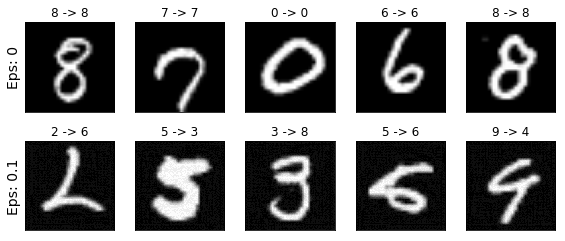

In [8]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()